In [1]:
# download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Install a particular version of `google-cloud-storage` because (oddly enough)
# the  version on Colab and GCP is old. A dependency error below is okay.
!pip install -q google-cloud-storage==1.43.0

In [3]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

# Run the app

In [4]:
# you need to upload your implementation of search_app.py
import search_backend
import search_frontend as se
import inverted_index_gcp

Loading dl_body.pkl...
Loading pageviews from pageviews-202108-user.pkl...
titles.db found locally.
Loading Title Index...
postings_gcp_title already exists. Skipping download.
Loading Body Index...
postings_gcp already exists. Skipping download.
Loading term_total.pkl...
Loading Anchor Index...
[SUCCESS] Download complete.


In [76]:
!rm search_backend.py

In [67]:
!rm search_frontend.py

In [77]:
# uncomment the code below and execute to reload the module when you make
# changes to search_frontend.py (after you upload again).
import importlib
importlib.reload(se)
importlib.reload(search_backend)

titles.db found locally.
Loading Title Index...
postings_gcp_title already exists. Skipping download.
Loading Body Index...
postings_gcp already exists. Skipping download.
Loading term_total.pkl...
Loading Anchor Index...
postings_gcp_anchor already exists. Skipping download.
Loading dl_body.pkl...
Loading pageviews from pageviews-202108-user.pkl...


<module 'search_backend' from '/content/search_backend.py'>

In [79]:
# find Colab's public URL
from google.colab.output import eval_js
server_url = eval_js("google.colab.kernel.proxyPort(5000)")
print(f"""Test your search engine by navigating to
{server_url}search?query=hello+world
This URL is only accessible from the same browser session. In other words, this
will not be accessible from a different machine, browser, or incognito session.
""")

# Uncomment the following line of code to run the frontend in the main
# process and wait for HTTP requests (colab will hang). The debug parameter
# lets you see incoming requests and get debug print outs if exceptions occur.
# se.run(debug=False, use_reloader=False)

# Alternatively, the next few lines run the frontend in a background process.
# Just don't forget to terminate the process when you update your search engine
# or want to reload it.
import multiprocessing, time
proc = multiprocessing.Process(target=se.run,
                               kwargs={"debug": True, "use_reloader": False,
                                       "host": "0.0.0.0", "port": 5000})
proc.start()

time.sleep(1) # give Flask time to boot

from google.colab.output import eval_js
server_url = eval_js("google.colab.kernel.proxyPort(5000)")

print(f"Open this URL:\n{server_url}/search?query=hello+world")
# Use proc.terminate() to stop the process

Test your search engine by navigating to
https://5000-m-s-a4txm50wifke-d.us-east1-0.prod.colab.devsearch?query=hello+world
This URL is only accessible from the same browser session. In other words, this
will not be accessible from a different machine, browser, or incognito session.

 * Serving Flask app 'search_frontend'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


Open this URL:
https://5000-m-s-a4txm50wifke-d.us-east1-0.prod.colab.dev/search?query=hello+world


# Testing your app

Once your app is running you can query it. You can simply do that by clicking on the URL printed above (the one looking like https://XXXXX-5000-colab.googleusercontent.com/search?query=hello+world or by issuing an HTTP request through code (from colab).

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [38]:
import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [39]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [40]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0


In [82]:
import requests
from time import time
# In GCP the public URL for your engine should look like this:
# url = 'http://35.232.59.3:8080'
# In colab, we are going to send HTTP requests to localhost (127.0.0.1)
# and direct them to port where the server is listening (5000).
VM_IP = "34.71.248.227"  # the url of the server created by the gcp instance
URL = f"http://{VM_IP}:8080"

qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      rq = results_quality(true_wids, pred_wids)
  except:
    pass

  qs_res.append((q, duration, rq))
  print((q, duration, rq))

('Mount Everest climbing expeditions', 0.8717596530914307, 0.595)
('Great Fire of London 1666', 5.380513668060303, 0.756)
('Nanotechnology materials science', 2.7730534076690674, 0.523)
('Fossil fuels climate change', 1.6638641357421875, 0.679)
('DNA double helix discovery', 1.1966724395751953, 0.528)
('Printing press invention Gutenberg', 1.9476888179779053, 0.636)
('Ancient Egypt pyramids pharaohs', 1.0687074661254883, 0.545)
('Gothic literature Mary Shelley', 1.9120147228240967, 0.405)
('Robotics automation industry', 1.1483383178710938, 0.466)
('Television invention broadcast media', 4.880232572555542, 0.161)
('Wright brothers first flight', 1.4830009937286377, 0.538)
('Steam locomotive transportation history', 0.8244016170501709, 0.224)
('Currency history gold standard', 2.1675827503204346, 0.484)
('Renaissance art Leonardo da Vinci', 2.0209176540374756, 0.624)
('Shakespeare plays Elizabethan theatre', 1.906843900680542, 0.495)
('Solar eclipse astronomy observation', 0.48494482040

SEARCH ENGINE PERFORMANCE REPORT
Total Queries:      30
Successful:         30
Failed:             0
----------------------------------------
Average Quality:    0.4904
Average Latency:    2.1799 sec


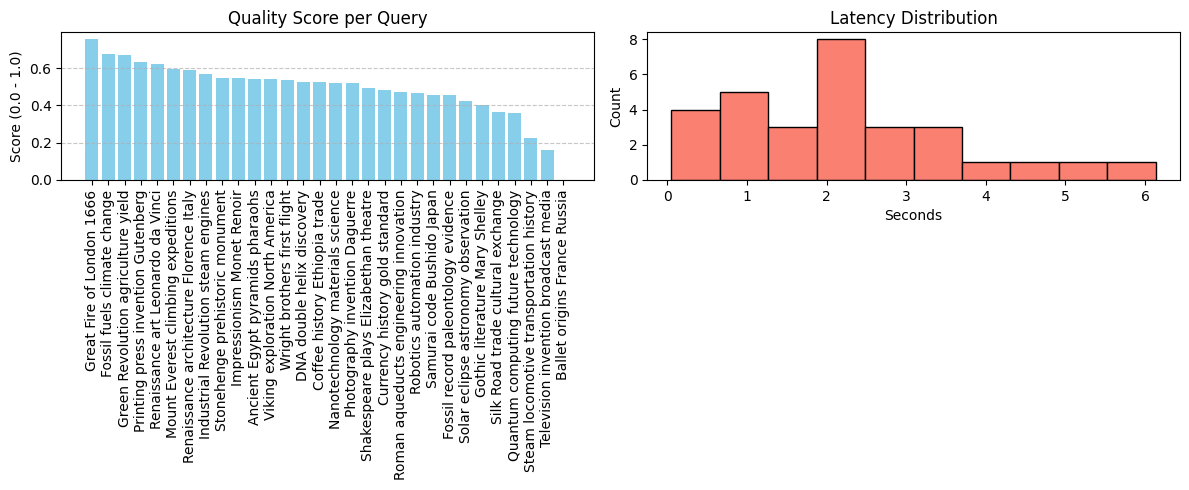


Detailed Results (Sorted by Worst Performing):


,Query,Duration,Score
29,Ballet origins France Russia,3.105481,0.000
9,Television invention broadcast media,4.880233,0.161
11,Steam locomotive transportation history,0.824402,0.224
23,Quantum computing future technology,2.382959,0.360
20,Silk Road trade cultural exchange,4.174911,0.363
7,Gothic literature Mary Shelley,1.912015,0.405
15,Solar eclipse astronomy observation,0.484945,0.425
19,Fossil record paleontology evidence,2.590340,0.455
18,Samurai code Bushido Japan,2.005933,0.458
8,Robotics automation industry,1.148338,0.466


In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a DataFrame from your results list
df_results = pd.DataFrame(qs_res, columns=['Query', 'Duration', 'Score'])

# 2. Filter out any failed queries (where Duration or Score is None)
df_clean = df_results.dropna()
failed_count = len(df_results) - len(df_clean)

# 3. Calculate Summary Statistics
mean_score = df_clean['Score'].mean()
mean_duration = df_clean['Duration'].mean()

# ---------------------------------------------------------
# PRINT SUMMARY REPORT
# ---------------------------------------------------------
print(f"{'='*40}")
print(f"SEARCH ENGINE PERFORMANCE REPORT")
print(f"{'='*40}")
print(f"Total Queries:      {len(df_results)}")
print(f"Successful:         {len(df_clean)}")
print(f"Failed:             {failed_count}")
print(f"{'-'*40}")
print(f"Average Quality:    {mean_score:.4f}")
print(f"Average Latency:    {mean_duration:.4f} sec")
print(f"{'='*40}")

# ---------------------------------------------------------
# VISUALIZATION
# ---------------------------------------------------------
if not df_clean.empty:
    plt.figure(figsize=(12, 5))

    # Plot Quality Scores
    plt.subplot(1, 2, 1)
    # Sort by score for better readability in the plot
    df_sorted = df_clean.sort_values('Score', ascending=False)
    plt.bar(df_sorted['Query'], df_sorted['Score'], color='skyblue')
    plt.xticks(rotation=90)
    plt.title('Quality Score per Query')
    plt.ylabel('Score (0.0 - 1.0)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Latency
    plt.subplot(1, 2, 2)
    plt.hist(df_clean['Duration'], bins=10, color='salmon', edgecolor='black')
    plt.title('Latency Distribution')
    plt.xlabel('Seconds')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# SHOW DETAILED TABLE (Sorted by Score)
# ---------------------------------------------------------
print("\nDetailed Results (Sorted by Worst Performing):")
# Display the dataframe with nice formatting
display(df_clean.sort_values(by='Score', ascending=True))

In [75]:
# Check if 'proc' exists and is running, then kill it
if 'proc' in globals() and proc.is_alive():
    proc.terminate()
    proc.join()
    print("Old server stopped.")

Old server stopped.
